In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [4]:
region = "BFC"

In [5]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [6]:
len(code_bss)

109

## Construction d'un dataframe

In [7]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [8]:
data

,05483X0041_P210,05005X0131_CG-21,04728X0050_F1,05031X0072_F1,05012X0024_F1,05822X0024_F1,05273X0134_F1,05266X0084_F1,05264X0055_F1,04706X0067_F1,...,04644X0002_PUITS,04643X0012_PUITS,05506X0032_PUITS,02967X0006_PUITS,04354X0026_PUITS,03673X0017_PUITS,03686X0038_PUITS,05282X0148_EAU,05797X0145_FPZ,04994X0528_FPZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1948-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,NaN,-11.29,-1.53,-20.37,-11.41,-1.38,0.32,-20.99,-0.23,-2.15,...,-21.01,NaN,-2.67,-48.21,-3.66,-34.90,-6.76,NaN,NaN,-22.77
2022-05-17,NaN,-11.30,NaN,-20.50,-11.41,-1.39,0.31,-21.01,-0.23,-2.15,...,-21.06,NaN,-2.68,-48.22,-3.69,-34.90,-6.77,NaN,NaN,-22.77
2022-05-18,NaN,-11.30,NaN,-20.69,-11.41,-1.41,0.31,-21.04,-0.24,-2.16,...,-21.09,NaN,-2.70,-48.22,-3.69,-34.90,-6.79,NaN,NaN,-22.86


## Visualisation des valeurs manquantes

In [9]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

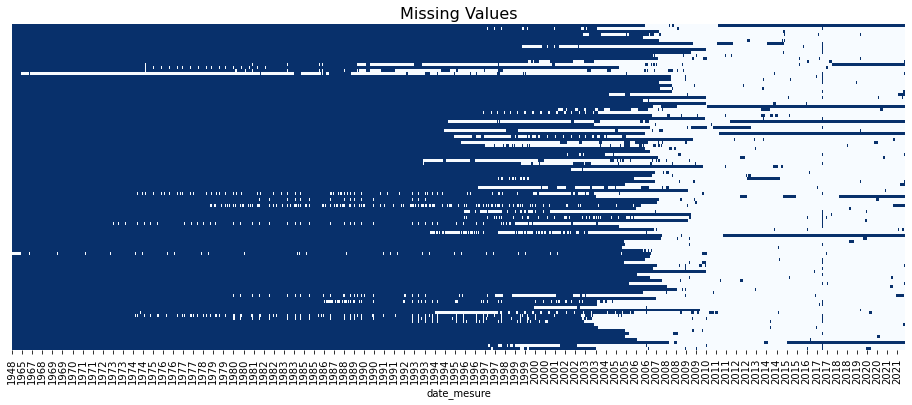

In [10]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [11]:
data_week = pd.DataFrame(data.resample('7D').mean())

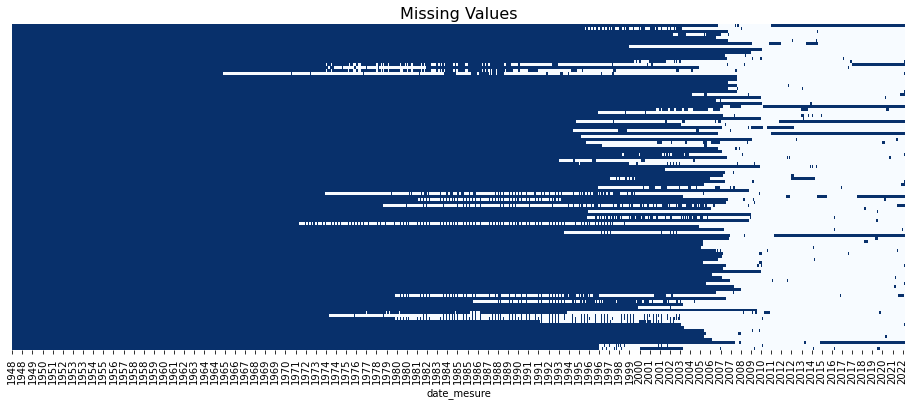

In [12]:
f_plot_nan(data_week)

In [13]:
data_week.shape

(3882, 109)

## Echelle de temps fixée après 2008 pour limiter les Nan

In [14]:
data_week_from_ = data_week.loc['01-01-2008':]

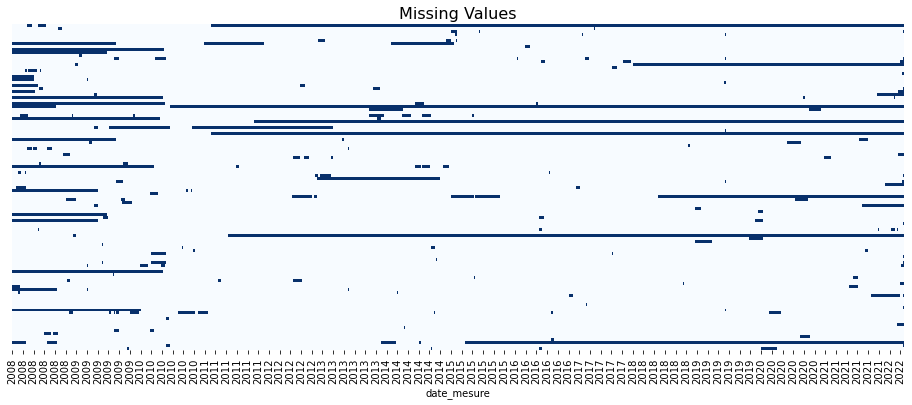

In [15]:
f_plot_nan(data_week_from_)

In [16]:
data_week_from_.shape

(751, 109)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [17]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 6443 valeurs nulles dans l'ensemble du dataframe.


In [18]:
data_wo_outliers = data_week_from_.copy()

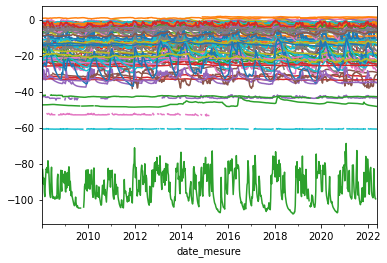

In [19]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

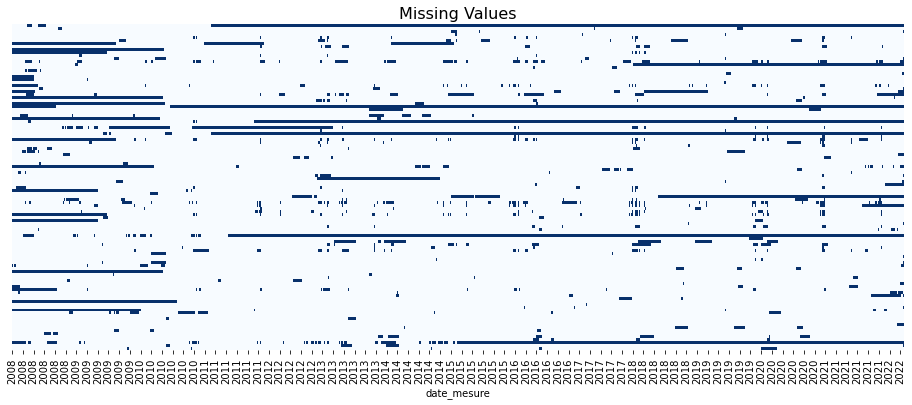

In [20]:
f_plot_nan(data_wo_outliers)

In [21]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 7840 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 10% de valeurs manquantes

In [22]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.10*data_wo_outliers.shape[0]].columns

In [23]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

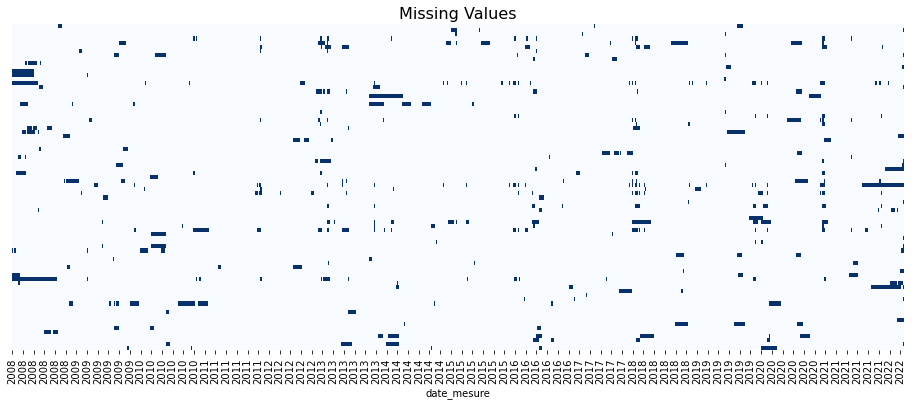

In [24]:
f_plot_nan(data_clean)

In [25]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 1337 valeurs nulles dans l'ensemble du dataframe.


In [26]:
data_clean.shape

(751, 80)

## Interpolation

In [27]:
data_interpol = data_clean.copy().interpolate('linear')

In [28]:
data_interpol.shape

(751, 80)

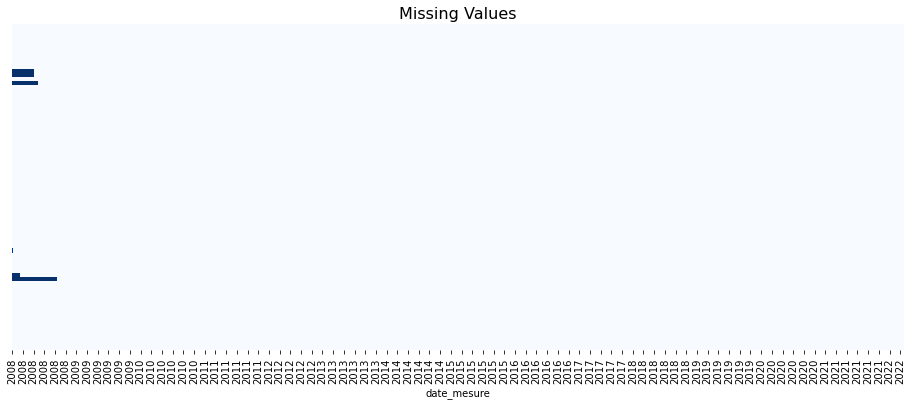

In [29]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [30]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [31]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-19 00:00:00', freq='7D')

In [32]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [33]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [34]:
data_interpol.shape

(713, 80)

In [35]:
data_interpol.shape[1]

80

## Affichage des chroniques après nettoyage

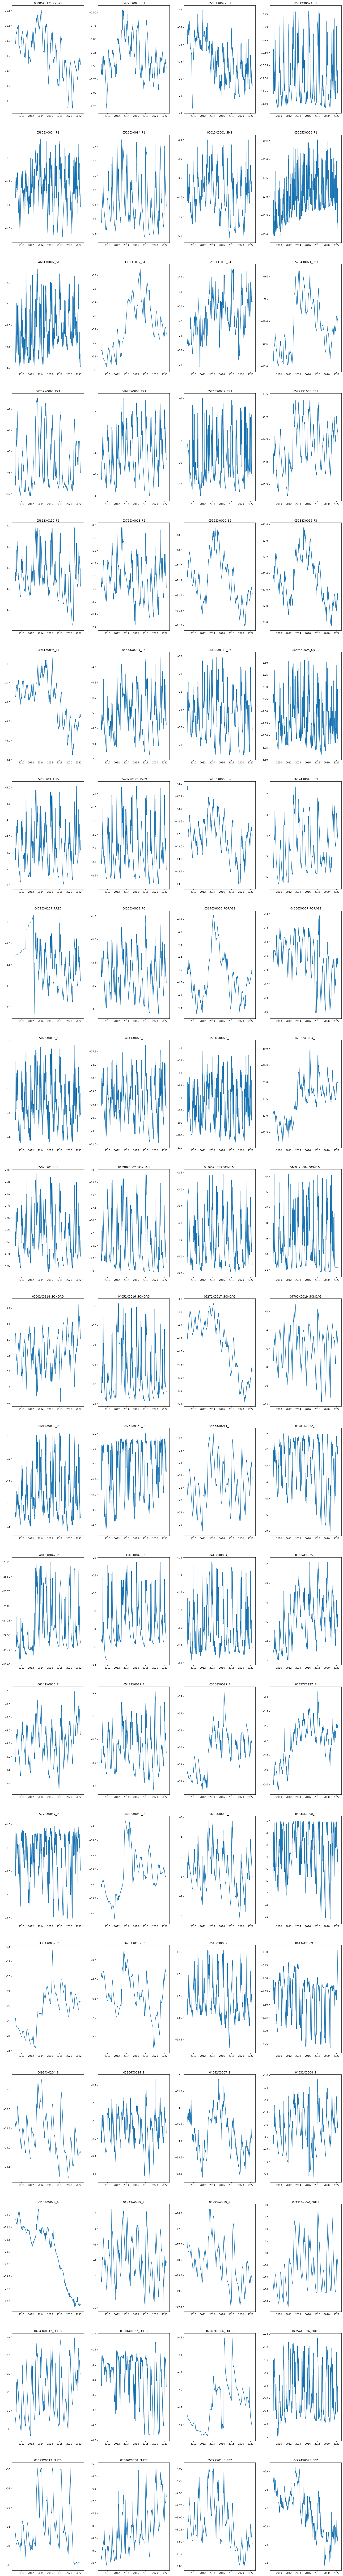

In [36]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

In [37]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [38]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [39]:
data_norm.head()

,05005X0131_CG-21,04728X0050_F1,05031X0072_F1,05012X0024_F1,05822X0024_F1,05266X0084_F1,05013X0001_SM1,05035X0003_P1,04661X0002_S1,03302X1012_S1,...,04994X0229_S,04644X0002_PUITS,04643X0012_PUITS,05506X0032_PUITS,02967X0006_PUITS,04354X0026_PUITS,03673X0017_PUITS,03686X0038_PUITS,05797X0145_FPZ,04994X0528_FPZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
2008-09-25,0.427842,-0.917478,1.175133,-0.104532,-0.451572,-0.825860,-0.015516,-1.894273,-1.423793,-1.041878,...,1.024280,-0.535623,-1.062567,-0.030827,-0.414144,-0.664276,-0.202204,-1.219567,-0.532796,1.506831
2008-10-02,0.470931,-0.690228,1.027752,-0.419356,-0.318807,-0.877915,-0.213234,-1.966997,-1.284436,-1.023965,...,0.928497,-0.610387,-1.114895,-0.291918,-0.423159,-0.654555,-0.259339,-1.191043,-0.564580,1.482527
2008-10-09,0.514020,-0.889570,0.898717,-0.572514,-0.269020,-0.840285,-0.299905,-1.821549,-1.289695,-1.020304,...,0.836970,-0.679755,-1.170213,-0.309925,-0.449078,-0.686957,-0.310241,-1.245090,-0.587696,1.616196
2008-10-16,0.557109,-0.825781,0.843678,-0.575350,0.062893,-0.815198,-0.121146,-0.906234,-0.745414,-1.021481,...,0.766728,-0.741031,-1.222968,0.053803,-0.467108,0.030511,-0.349716,-1.279620,-0.573248,1.516552
2008-10-23,0.600199,-0.813820,0.843678,0.346432,0.403104,-0.703981,0.943283,-0.728186,-0.282644,-1.026973,...,0.745443,-0.797682,-1.272092,0.617401,-0.487392,1.152230,-0.390230,-1.309646,-0.512569,1.489818


## Sauvegarde du dataframe en csv

In [40]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")